In [67]:
import jax
import jax.numpy as jnp
import jax.random as random
import optax
import scipy as sp

from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm


import sys
import os
sys.path.append('../')
sys.path.append('../power_law_rf')
import optimizers
#import power_law_rf as plrf
import power_law_rf.power_law_rf as plrf
from power_law_rf.power_law_rf import PowerLawRF
from power_law_rf.ode import ode_resolvent_log_implicit
from power_law_rf.ode import DanaHparams
from power_law_rf.ode import ODEInputs#
from power_law_rf.least_squares import lsq_streaming_optax_simple
import power_law_rf.deterministic_equivalent as theory

key = random.PRNGKey(0)

In [68]:
def run_odes(ALPHA,BETA,D,V, kappa_1, kappa_2, kappa_3, kappa_b, key = key, C = 0.5):   
    STEPS = 10**3 * D**(2*ALPHA)
    SGDBATCH=D**(kappa_b)
    key, subkey = random.split(key)
    problem = PowerLawRF.initialize_random(alpha=ALPHA, beta=BETA, v=V, d=D, key=subkey)
    Delta = optimizers.powerlaw_schedule(1.0, 0.0, -1.0, 4.0+2*(problem.alpha+problem.beta)/(2*problem.alpha))
    g1 = optimizers.powerlaw_schedule(1.0, 0.0, 0.0, 1)
    g2 = optimizers.powerlaw_schedule(0.5 * D**(-kappa_1), 0.0, 0.0, 1)
    g3 = optimizers.powerlaw_schedule(0.5 * C * D**(-kappa_2), 0.0, -kappa_3, 1)


    #Initialize the rhos
    initTheta = jnp.zeros(problem.d, dtype=jnp.float32)
    initY = jnp.zeros(problem.d, dtype=jnp.float32)
    rho_init = problem.get_rhos()
    sigma_init = jnp.zeros_like(rho_init)
    chi_init = jnp.zeros_like(rho_init)
    fake_eigs,rho_init = theory.theory_rhos(problem.alpha,problem.beta,problem.d)
    riskInftyTheory=problem.get_theory_limit_loss()

    Dt = 10**(-2)

    odeTimes, odeRisks = ode_resolvent_log_implicit(
        ODEInputs(fake_eigs, rho_init, chi_init, sigma_init, riskInftyTheory),
        DanaHparams(g1, g2, g3, Delta),
        SGDBATCH, problem.d, STEPS, Dt)
    return (odeTimes, odeRisks)

100%|██████████| 13/13 [00:14<00:00,  1.13s/it]


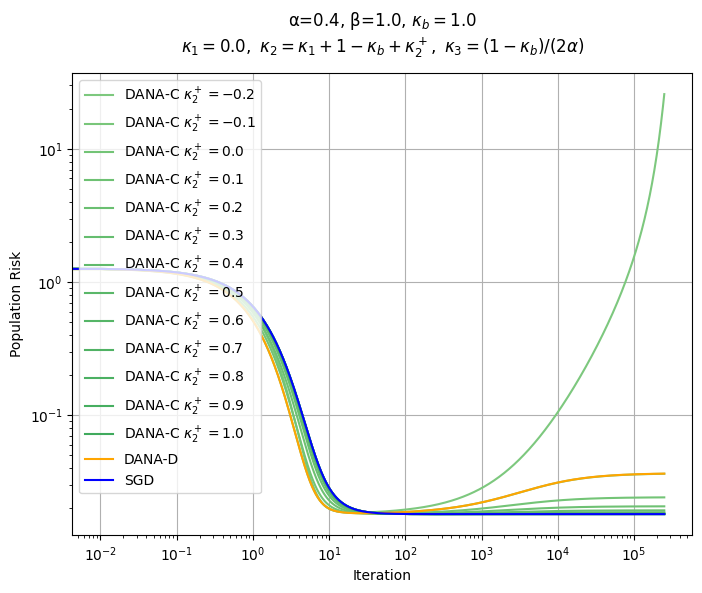

In [69]:
ALPHA = 0.4
BETA = 1.0
kappa_b = 1.0

plt.figure(figsize=(8,6))
for D in [1000]:
    V = 5*D
    kappa_1 = max(0, max(0, 1-2*ALPHA) - kappa_b)
    kappa_3 = 0.0
    for kappa_2_ in tqdm([-0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]):
        color = cm.Greens((kappa_2_ +4.0)/8.0)
        kappa_2 = kappa_1 + 1 - kappa_b + kappa_2_
        #kappa_2 = max(0, kappa_2)
        (odeTimes_dana_constant, odeRisks_dana_constant) = run_odes(ALPHA,BETA,D,V,kappa_1,kappa_2,kappa_3,kappa_b)
        plt.loglog(odeTimes_dana_constant, odeRisks_dana_constant, label=f'DANA-C $\kappa_2^+={kappa_2_:.1f}$', color=color)
    (odeTimes_dana_decay, odeRisks_dana_decay) = run_odes(ALPHA,BETA,D,V,kappa_1,kappa_2 = 0.,kappa_3 =(1-kappa_b)/(2*ALPHA),kappa_b = kappa_b, C=.5)
    plt.loglog(odeTimes_dana_decay, odeRisks_dana_decay, label='DANA-D', color = 'orange')
    (odeTimes_sgd, odeRisks_sgd) = run_odes(ALPHA,BETA,D,V,kappa_1,kappa_2 = 0.,kappa_3 = 0.,kappa_b = kappa_b, C=0.0)
    plt.loglog(odeTimes_sgd, odeRisks_sgd, label='SGD', color = 'blue')

plt.xlabel('Iteration')
plt.ylabel('Population Risk')
#plt.ylim(0.0, 10**2)
plt.title(f'α={ALPHA:.1f}, β={BETA:.1f}, $\kappa_b=${kappa_b:.1f}'+ f'\n$\kappa_1 = {kappa_1:.1f},\ \kappa_2= \kappa_1 + 1 - \kappa_b + \kappa_2^+,\ \kappa_3=(1-\kappa_b)/(2 α)$', pad=15, fontsize=12)
plt.legend()
plt.grid(True)
#plt.savefig(f'../figs/batch_scaling_kappa_b_{kappa_b}_alpha_{ALPHA:.1f}_beta_{BETA:.1f}.png')